In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get the dataset

In [2]:
!wget --no-check-certificate \
    -O /tmp/sentiment.csv https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P

--2020-06-07 12:38:03--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 64.233.167.139, 64.233.167.138, 64.233.167.102, ...
Connecting to drive.google.com (drive.google.com)|64.233.167.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mlnp5b1o1j1pagilthd0q3ebbvit59oe/1591533450000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2020-06-07 12:38:03--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mlnp5b1o1j1pagilthd0q3ebbvit59oe/1591533450000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 173.194.76.132, 2a00:1450:400c:c00::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|173.19

In [0]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Tokenize the dataset

In [0]:
vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words= vocab_size, oov_token= oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(sequences=training_sequences , maxlen = max_length, padding= padding_type, truncating= trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(sequences=testing_sequences , maxlen = max_length, padding= padding_type, truncating= trunc_type)


# Review a Sequence

In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(training_padded[1]))
print(training_sentences[1])

good case excellent value ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Good case Excellent value.


# Train a Basic Sentiment Model with Embeddings

In [0]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length= max_length),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [8]:
epochs = 30

history = model.fit(training_padded, training_labels_final, epochs= epochs ,validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 0s 9ms/step - loss: 0.6927 - accuracy: 0.5091 - val_loss: 0.6937 - val_accuracy: 0.4185
Epoch 2/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6907 - accuracy: 0.5254 - val_loss: 0.6945 - val_accuracy: 0.4185
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6864 - accuracy: 0.5317 - val_loss: 0.6925 - val_accuracy: 0.4511
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6770 - accuracy: 0.6183 - val_loss: 0.6881 - val_accuracy: 0.4762
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6644 - accuracy: 0.6403 - val_loss: 0.6790 - val_accuracy: 0.5338
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.6467 - accuracy: 0.6792 - val_loss: 0.6664 - val_accuracy: 0.5514
Epoch 7/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6237 - accuracy: 0.7389 - val_loss: 0.6499 - val_accuracy: 0.5789
Epoch 8/30
50/50 [==

# Visualize the training graph

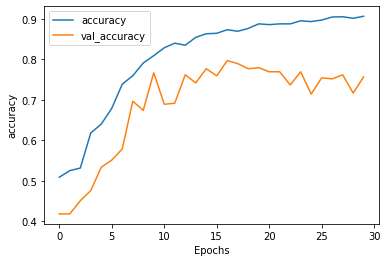

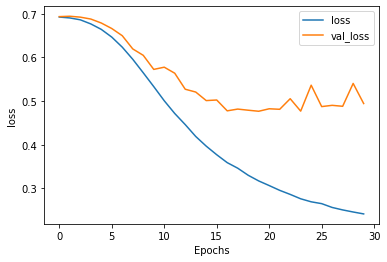

In [9]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_{}'.format(string)])
  plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Get files for visualizing the network

In [13]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(500, 16)


In [0]:
import io

# Create the reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [0]:
# load the site
# http://projector.tensorflow.org/

# Predicting Sentiment in New Reviews


In [16]:
# Use the model to predict a review   
fake_reviews = ['I love this phone', 'I hate spaghetti', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes', 
                'does not work when I stand on my head']

print(fake_reviews) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  print(classes[x])
  print('\n')

# Try adding reviews of your own
# Add some negative words (such as "not") to the good reviews and see what happens
# For example:
# they gave us free chocolate cake and did not charge us

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'does not work when I stand on my head']

HOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!

I love this phone
[0.9228869]


I hate spaghetti
[0.11231055]


Everything was cold
[0.5628021]


Everything was hot exactly as I wanted
[0.38162753]


Everything was green
[0.5628021]


the host seated us immediately
[0.56115943]


they gave us free chocolate cake
[0.87127215]


not sure about the wilted flowers on the table
[0.06007138]


only works when I stand on tippy toes
[0.8849269]


does not work when I stand on my head
[0.02721222]


